In [44]:
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm import tqdm
import sys
import corner

sys.path.append("../")

import tdpy

In [35]:
def gen_arr(config, bin=True, n=12000):
    n_secondary = config["n_secondary"]
    l = bin*len(config["binary"].keys()) + n_secondary*len(config["secondary_0"].keys()) + 1
    arr = np.zeros((n, l))*np.nan
    keys = []
    keys.append("m_star")
    for i in range(0, n_secondary):
        for key in config["secondary_0"].keys():
            keys.append(f"{i}/{key}")
    if bin:
        for key in config["binary"].keys():
            keys.append(f"bin/{key}")
    
    return arr, keys




def add_to_array(arr, config, keys, i, bin=True, n=12000):
    if not np.any(arr):
        arr, keys = gen_arr(config, bin=bin, n=n)
        
    n_secondary = config["n_secondary"]
    arr[i, 0] = config["m_star"]
    j = 1
    
    for k in range(0, n_secondary):
        for key in config["secondary_0"].keys():
            arr[i, j] = config[f"secondary_{k}"][key]
            j += 1
    if bin:
        for key in config["binary"].keys():
            arr[i, j] = config["binary"][key]
            j += 1
    
    return arr, keys
    

In [65]:
dir = "detailed_bin"
system = "Kepler-220"

keys = None
arr = None
j = 0
for i in tqdm(range(1, 12000)):
    try:
        with open(f"../output/{dir}/{system}/{i}/config.json") as f:
            cfg = json.load(f)
            arr, keys = add_to_array(arr, cfg, keys, j, bin=False)
            j += 1
    except Exception as e:
        # print(e)
        pass
arr = arr[:j, :]

100%|██████████| 11999/11999 [00:39<00:00, 300.95it/s]


In [39]:
arr

array([[ 0.71608011,  0.29178834,  0.05189799, ..., -0.20594897,
        -1.18195949, -2.6288225 ],
       [ 0.74678966,  0.30426087,  0.05031779, ...,  0.13610629,
         1.52546569,  1.99312075],
       [ 0.73195254,  0.37184102,  0.04995948, ...,  0.03809229,
         0.84366879,  2.8836633 ],
       ...,
       [ 0.7220042 ,  0.29950687,  0.05344317, ..., -0.09203006,
        -0.17052514, -3.13529919],
       [ 0.71608011,  0.29178834,  0.05189799, ..., -0.20594897,
        -1.18195949, -2.6288225 ],
       [ 0.7220042 ,  0.29950687,  0.05344317, ..., -0.09203006,
        -0.17052514, -3.13529919]])

In [43]:
np.corrcoef(arr, rowvar=0)

array([[ 1.00000000e+00,  5.41635239e-01, -1.07738785e-01,
         6.35165627e-01, -2.53037241e-01, -7.14125461e-01,
        -3.64664345e-01, -1.88025548e-02,  2.90762593e-03,
        -1.93238101e-01, -6.40543814e-02,  3.79898320e-01,
         4.53164381e-01,  9.92675719e-02,  2.37380002e-01,
         3.19193983e-01,  5.55568030e-01, -4.14524322e-01,
        -4.27133663e-01,  2.96825764e-01,  3.94108409e-01,
         6.33819520e-01,  4.41356806e-01,  2.47444227e-01,
         6.85421797e-01],
       [ 5.41635239e-01,  1.00000000e+00, -3.26887043e-01,
         5.29118937e-01, -2.66229050e-01, -6.56226425e-01,
        -4.87305893e-01, -9.82144031e-02, -1.31139952e-01,
        -9.73132108e-02,  6.75732177e-02,  3.57115175e-01,
         6.32410219e-01, -9.51839432e-02,  1.33849857e-01,
         2.39683258e-01,  1.56948788e-01, -2.87033685e-01,
        -4.22716995e-01,  9.18351972e-02,  2.23744955e-01,
         5.47196047e-01,  5.78519524e-01,  4.66841626e-01,
         5.30476637e-01],
    

ValueError: It looks like the parameter(s) in column(s) 4 have no dynamic range. Please provide a `range` argument.

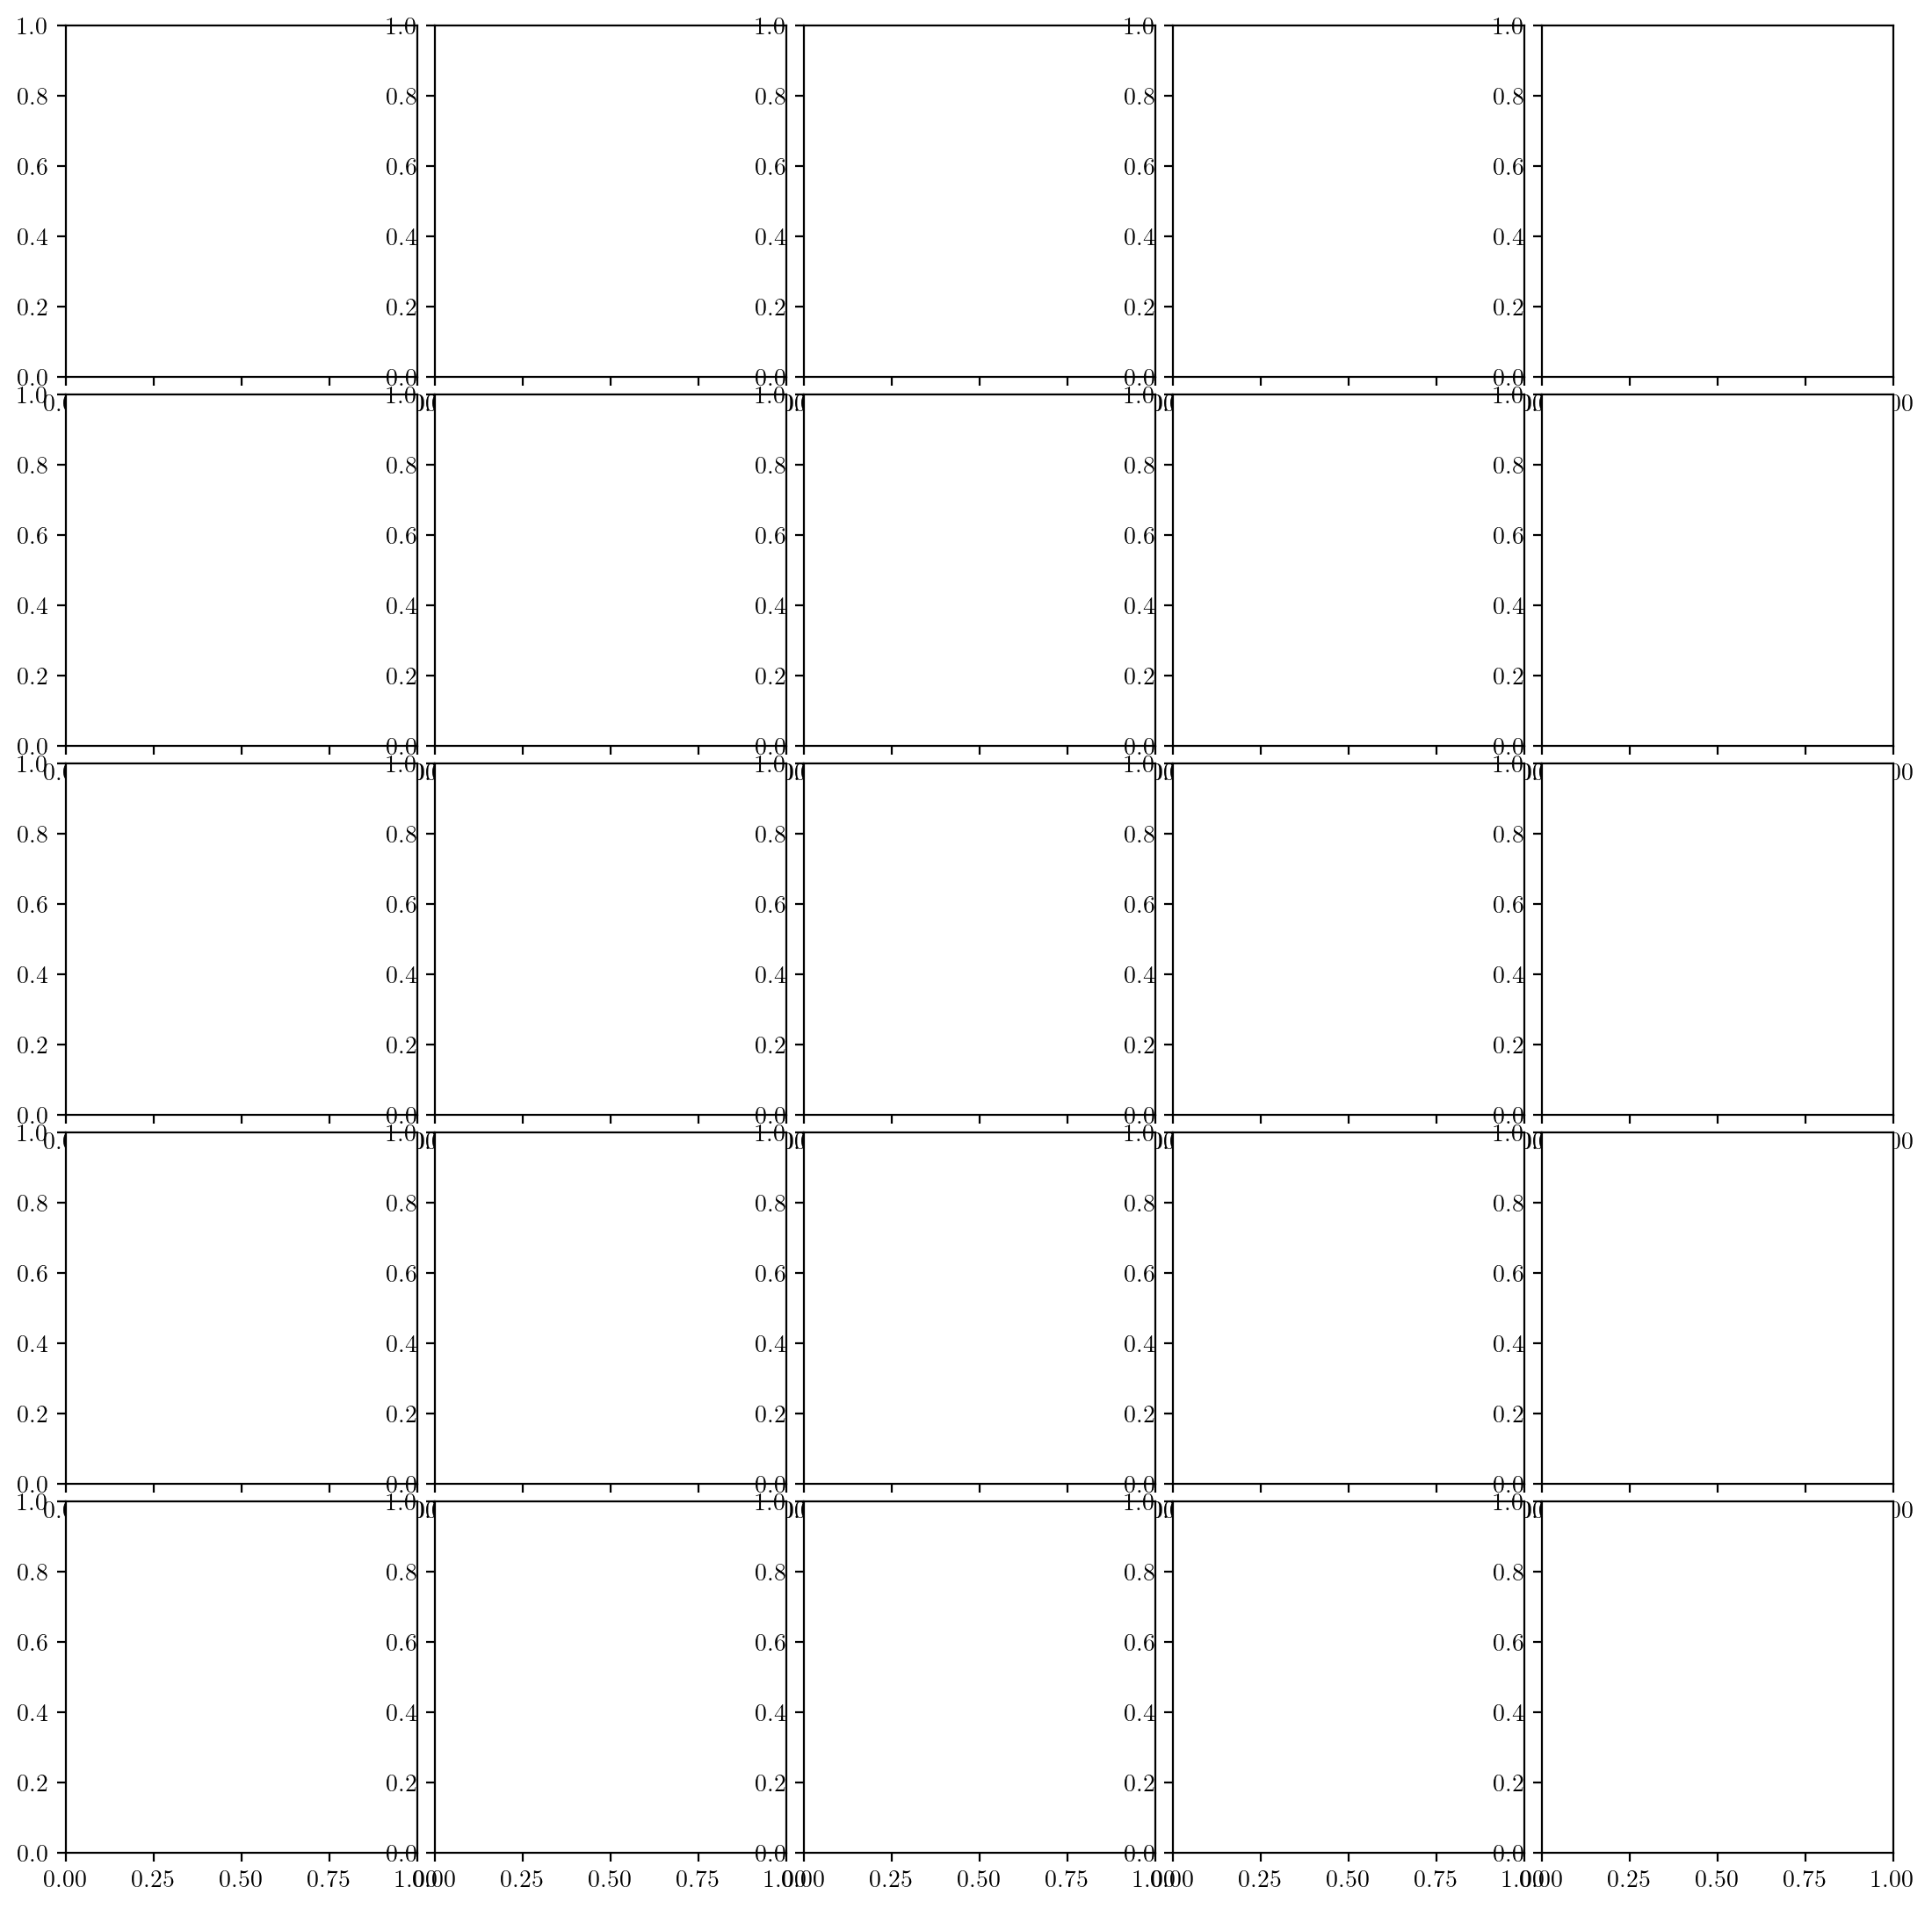

In [66]:
corner.corner(arr[:,:5])

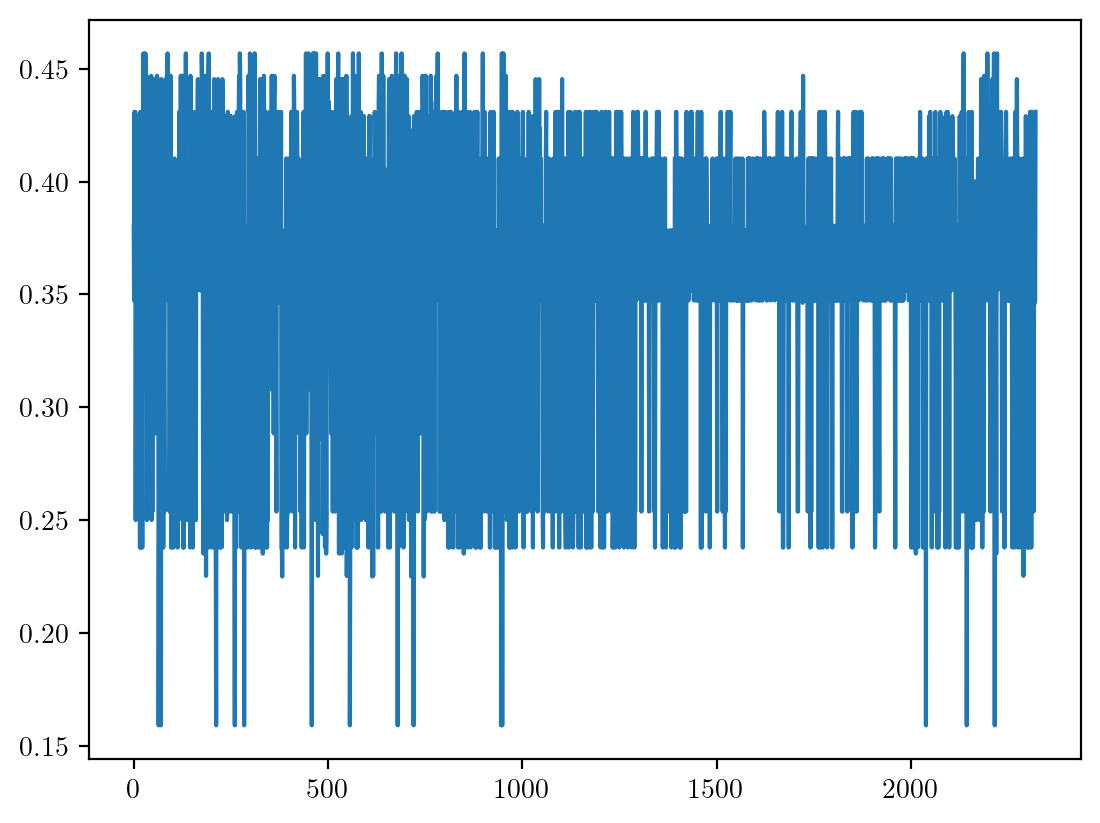

In [67]:
plt.plot(arr[:,1])

(array([167., 381., 324.,   1.,  69.,   0.,   0.,   0.,  43.,   5.,   4.,
          0.,   1., 167., 342.,   0.,   0.,   6.,   0.,   0.,   2.,  10.,
          0.,  22.,   5., 314.,   4.,   2.,   0.,   0.,   0., 171.,   1.,
          1.,  37.,   8.,   1.,   1.,   1.,  30., 163.,   0.,   0.,   8.,
          0.,  14.,   1.,   4.,   5.,   6.]),
 array([-2.87030186, -2.75393769, -2.63757352, -2.52120935, -2.40484518,
        -2.28848101, -2.17211684, -2.05575267, -1.9393885 , -1.82302433,
        -1.70666016, -1.59029599, -1.47393182, -1.35756765, -1.24120347,
        -1.1248393 , -1.00847513, -0.89211096, -0.77574679, -0.65938262,
        -0.54301845, -0.42665428, -0.31029011, -0.19392594, -0.07756177,
         0.0388024 ,  0.15516657,  0.27153074,  0.38789491,  0.50425908,
         0.62062325,  0.73698743,  0.8533516 ,  0.96971577,  1.08607994,
         1.20244411,  1.31880828,  1.43517245,  1.55153662,  1.66790079,
         1.78426496,  1.90062913,  2.0169933 ,  2.13335747,  2.24972164,
 

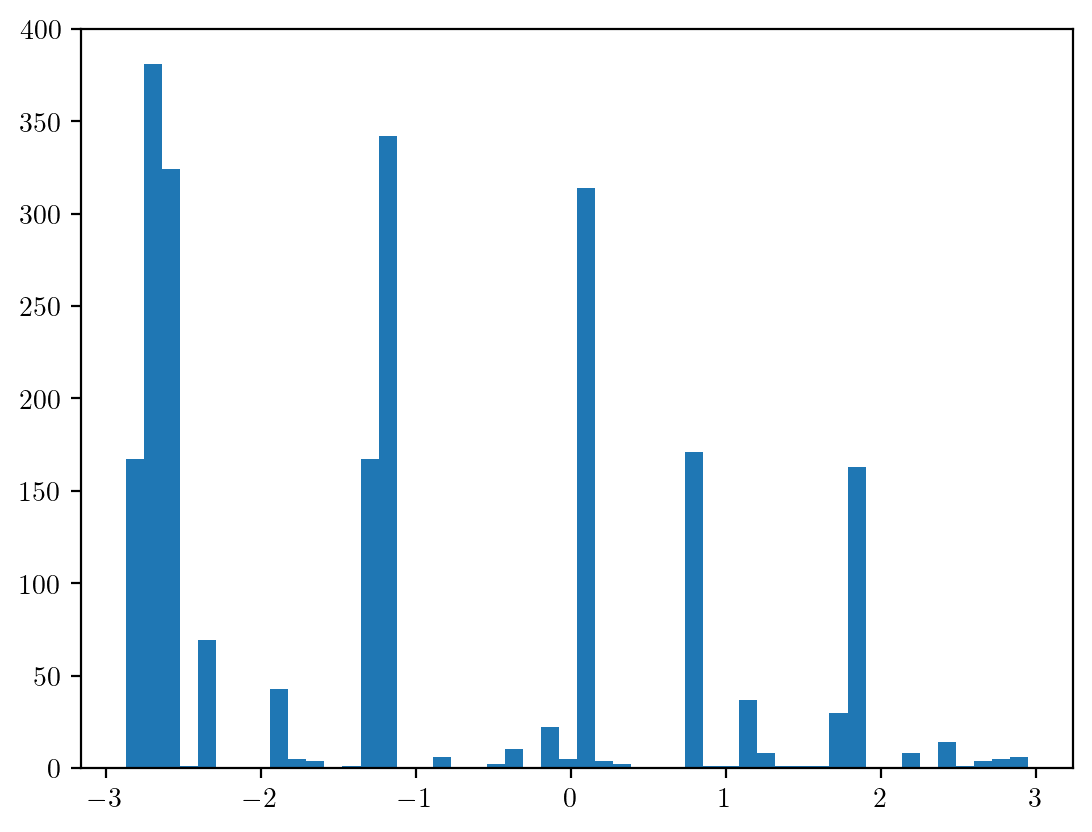

In [75]:
plt.hist(arr[:, 6], bins=50)

In [74]:
keys[6]

'0/Omega'